# FIND BETTER NAME!!!!!

#### Classification models:
In order to get a perspective of the preformance we can achive, we tried using the following models:
- Logistic Regression
- KNN
- SVM
- Decision Tree
- Random Forest
- Neural Network
- LSTM model
- A combination of all models

All predictions are written into csv files at the end of the process.

#### Draw class:
As we saw on our first attempt classifier, the classifier never chose the draw class, to deal with this issue we had te drop/duplicate some samples in order to get same amount of samples for each class. 



#### General Impotrs:

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle

def save_obj(obj, name ):
    with open('databases/objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('databases/objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Read all DB's:

In [3]:
current_leagues = ["England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"]

#Availible Leagues:
#"England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"

#Not Availible Leagues (yet):
#Italy_Serie_A/Switzerland_Super_League

In [4]:
window_size = load_obj("window_size")

In [5]:
basic_info       = ["index","league","season","stage","home_team_name","away_team_name","score"]
betting_odds     = ["B365H","WHH","VCH","B365A","WHA","VCA","B365D","WHD","VCD"]
last_games_wld   = [str(x)+"_last_wld" for x in list(range(1,window_size))]
window_features  = [str(x)+"_pos_goals" for x in list(range(2,window_size))]+[str(x)+"_neg_goals" for x in list(range(2,window_size))]+[str(x)+"_wins" for x in list(range(2,window_size))]+[str(x)+"_loses" for x in list(range(2,window_size))]+[str(x)+"_draws" for x in list(range(2,window_size))]
new_features     = ["points","norm_points","position","straight_wins","straight_loses","straight_draws","tot_pos_goals","tot_neg_goals","goals_diff"] + window_features# + last_games_wld
important_info   = basic_info + ["home_team_goal","away_team_goal"]

percent_per_season_columns = ["home_win_season_percent","home_lose_season_percent","home_draw_season_percent","away_win_season_percent","away_lose_season_percent","away_draw_season_percent"]
percent_total_columns      = ["home_win_percent","home_lose_percent","home_draw_percent","away_win_percent","away_lose_percent","away_draw_percent"]

home_away        = ["home","away"]

new_columns      = important_info + betting_odds

new_new_columns = []

for r in itertools.product(home_away,new_features): new_new_columns.append(r[0] +"_"+ r[1])

In [6]:
features_list = new_new_columns + percent_per_season_columns + percent_total_columns + betting_odds# + ["stage"]
labels_list   = "win_lose_draw"

In [7]:
final_matches_db = pd.read_csv("databases/my_matches_db.csv", encoding='latin-1', index_col = [0])

In [8]:
all_leagues = final_matches_db["league"].unique()

for league in all_leagues:
    if league.replace(" ","_") in current_leagues: continue
    final_matches_db = final_matches_db[final_matches_db["league"] != league]

In [9]:
final_matches_db.reset_index(inplace=True)
final_matches_db.dropna(axis = 0,inplace=True)

In [10]:
final_matches_db

,index,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
40,40,England Premier League,2008/2009,5,Liverpool,Stoke City,0 - 0,10.0,1.000000,2.0,...,1.20,1.20,1.20,15.00,15.00,17.00,6.50,6.00,6.50,0
41,41,England Premier League,2008/2009,5,Sunderland,Middlesbrough,2 - 0,4.0,0.400000,17.0,...,2.38,2.30,2.25,3.20,3.20,3.35,3.10,3.20,3.30,1
42,42,England Premier League,2008/2009,5,Tottenham Hotspur,Wigan Athletic,0 - 0,1.0,0.100000,20.0,...,1.73,1.70,1.70,5.00,5.50,5.50,3.60,3.40,3.60,0
43,43,England Premier League,2008/2009,5,West Ham United,Newcastle United,3 - 1,6.0,0.600000,8.0,...,2.10,2.00,2.00,3.60,3.80,3.80,3.30,3.30,3.50,1
44,44,England Premier League,2008/2009,5,Manchester City,Portsmouth,6 - 0,6.0,0.600000,7.0,...,2.00,2.00,2.05,4.00,3.80,3.80,3.30,3.30,3.35,1
45,45,England Premier League,2008/2009,5,Blackburn Rovers,Fulham,1 - 0,4.0,0.400000,18.0,...,2.10,2.10,2.05,3.60,3.50,3.75,3.30,3.30,3.40,1
46,46,England Premier League,2008/2009,5,Bolton Wanderers,Arsenal,1 - 3,4.0,0.400000,14.0,...,6.50,6.00,6.20,1.57,1.62,1.60,3.75,3.60,3.80,2
47,47,England Premier League,2008/2009,5,West Bromwich Albion,Aston Villa,1 - 2,4.0,0.400000,15.0,...,3.25,2.90,3.30,2.25,2.40,2.25,3.30,3.30,3.35,2
48,48,England Premier League,2008/2009,5,Hull City,Everton,2 - 2,7.0,0.700000,6.0,...,3.10,3.25,3.15,2.30,2.25,2.30,3.40,3.25,3.40,0
49,49,England Premier League,2008/2009,5,Chelsea,Manchester United,1 - 1,10.0,1.000000,1.0,...,2.20,2.20,2.20,3.60,3.60,3.70,3.10,3.00,3.10,0


#### Functions:

In [11]:
def drop_samples(features,labels,random_state=None):
    min_samples = labels["win_lose_draw"].value_counts().min()
    rr = []
    for label in  labels["win_lose_draw"].unique():
        ee = list(labels[labels["win_lose_draw"] == label].index)
        random.seed(random_state)
        random.shuffle(ee)
        rr = rr + ee[min_samples:]
        
    return features.drop(rr), labels.drop(rr)
        
def duplicate_samples(features,labels,random_state=None):
    max_samples = labels["win_lose_draw"].value_counts().max()
    rr = []
    for label in labels["win_lose_draw"].unique():
        ee = list(labels[labels["win_lose_draw"] == label].index)
        sam_to_add = max_samples - len(ee)
        dd = ee.copy()
        random.seed(random_state)
        random.shuffle(dd)
        rr = rr + ee + dd[:sam_to_add]
        
    return features.loc[rr], labels.loc[rr]

In [12]:
def split_data_according_season(features, labels, test_size,random_state=None):
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_seasons = features["season"].unique()
    all_leagues = features["league"].unique()
    
    num_of_seasons    = len(all_seasons)
    test_num_seasons  = round(num_of_seasons*test_size)
    train_num_seasons = num_of_seasons-test_num_seasons
        
    for league in all_leagues:
        random.seed(random_state)
        random.shuffle(all_seasons)

        train_seasons = all_seasons[:train_num_seasons]
        test_seasons  = all_seasons[train_num_seasons:]

        printmd('**' + league + ':**')
        print("train_leagues =",train_seasons)
        print("test_leagues  =",test_seasons)

        X_train[league] = features[(features["league"] == league) & (features["season"].isin(train_seasons))]
        X_test[league]  = features[(features["league"] == league) & (features["season"].isin(test_seasons))]
        y_train[league] = labels[(labels["league"] == league) & (labels["season"].isin(train_seasons))]
        y_test[league]  = labels[(labels["league"] == league) & (labels["season"].isin(test_seasons))]
    
    aa = pd.concat(X_train)
    aa.index = aa.index.droplevel()
    bb = pd.concat(X_test)
    bb.index = bb.index.droplevel()
    cc = pd.concat(y_train)
    cc.index = cc.index.droplevel()
    dd = pd.concat(y_test)
    dd.index = dd.index.droplevel()
    
    return aa,bb,cc,dd

In [13]:
def get_split_func(split_mode):
    return {
        "according_season": split_data_according_season,
        "default":          train_test_split
    }.get(split_mode,train_test_split)

def get_balance_samples_func(split_mode):
    return {
        "drop":      drop_samples,
        "duplicate": duplicate_samples
    }.get(split_mode,drop_samples)

In [14]:
import numpy as np
from sklearn.decomposition import PCA

def plot_soft_decision_plan(model_name,model_predictions,real_labels):
    pca = PCA(n_components=2)
    pca.fit(model_predictions)

    tt = pca.transform(model_predictions)
    df = pd.DataFrame(tt,index=real_labels.index)
    df["real_labels"] = real_labels
    df["predictions"] = pd.Series(model_predictions.argmax(axis=1),index=real_labels.index)

    fig, (ax1, ax2) = plt.subplots(figsize = (20, 6), ncols = 2, sharey = True)
    fig.suptitle("model_name = " + model_name,fontsize=22)
    ax1.set_title("real_labels", fontsize = 18)
    ax2.set_title("predictions", fontsize = 18)
    
    colors = {0:'red', 1:'blue', 2:'green'}

    grouped = df.groupby('real_labels')
    for key, group in grouped:
        group.plot(ax=ax1, kind='scatter', x=0, y=1, label=key, color=colors[key])
        
    grouped = df.groupby('predictions')
    for key, group in grouped:
        group.plot(ax=ax2, kind='scatter', x=0, y=1, label=key, color=colors[key])

    plt.show()

#### Hyperparameters:

In [15]:
split_mode  = "according_season" #"default/according_season"
test_size   = 0.30
seed        = None#100

balance_mode = "drop" #drop/duplicate

threshold_1 = 1.5
threshold_2 = {1:0.45,2:0.35}

#### Split the data:

In [16]:
from sklearn.model_selection import train_test_split
import random

In [17]:
info_list = ["index","league","season","stage","home_team_name","away_team_name"]
features  = final_matches_db[info_list + features_list]
labels    = final_matches_db[info_list + [labels_list]]

In [18]:
print("Num of features =",len(features_list))

Num of features = 69


In [19]:
X_train_original, X_test_original, y_train_original, y_test_original = get_split_func(split_mode)(features, labels, test_size=test_size, random_state=seed)

**England Premier League:**

train_leagues = ['2008/2009' '2014/2015' '2010/2011' '2011/2012' '2012/2013' '2009/2010']
test_leagues  = ['2013/2014' '2015/2016']


**France Ligue 1:**

train_leagues = ['2008/2009' '2010/2011' '2011/2012' '2009/2010' '2015/2016' '2012/2013']
test_leagues  = ['2013/2014' '2014/2015']


**Germany 1. Bundesliga:**

train_leagues = ['2010/2011' '2009/2010' '2013/2014' '2014/2015' '2011/2012' '2015/2016']
test_leagues  = ['2008/2009' '2012/2013']


**Netherlands Eredivisie:**

train_leagues = ['2012/2013' '2009/2010' '2015/2016' '2014/2015' '2008/2009' '2010/2011']
test_leagues  = ['2011/2012' '2013/2014']


**Spain LIGA BBVA:**

train_leagues = ['2011/2012' '2012/2013' '2010/2011' '2015/2016' '2013/2014' '2014/2015']
test_leagues  = ['2008/2009' '2009/2010']


In [20]:
printmd('**Before ' + balance_mode + ' samples:**')
print(y_train_original["win_lose_draw"].value_counts(),"\n")

X_train_original,y_train_original = get_balance_samples_func(balance_mode)(X_train_original,y_train_original,random_state=seed)

printmd('**After ' + balance_mode + ' samples:**')
print(y_train_original["win_lose_draw"].value_counts())

**Before drop samples:**

1    4363
2    2630
0    2351
Name: win_lose_draw, dtype: int64 



**After drop samples:**

2    2351
1    2351
0    2351
Name: win_lose_draw, dtype: int64


In [21]:
X_train_def = X_train_original[features_list]
X_test_def  = X_test_original[features_list]
y_train_def = y_train_original[labels_list]
y_test_def  = y_test_original[labels_list]

####  Logistic Regression model

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
logmodel = LogisticRegression()

In [24]:
logmodel.fit(X_train_def,y_train_def)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
predictions = logmodel.predict(X_test_def)

#### Learning Evaluation:

In [26]:
from sklearn.metrics import classification_report,confusion_matrix

In [27]:
print(classification_report(y_test_def,predictions))

             precision    recall  f1-score   support

          0       0.28      0.38      0.32       755
          1       0.66      0.51      0.57      1468
          2       0.47      0.50      0.48       895

avg / total       0.51      0.47      0.49      3118



In [28]:
print(confusion_matrix(y_test_def,predictions))

[[288 230 237]
 [448 743 277]
 [287 160 448]]


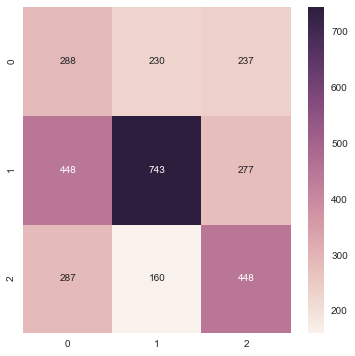

In [29]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_def,predictions),annot=True, fmt="d")

In [30]:
coeff_df = pd.DataFrame(logmodel.coef_.T,features_list,
                        columns=['Coefficient_home','Coefficient_away','Coefficient_draw'])
coeff_df

,Coefficient_home,Coefficient_away,Coefficient_draw
home_points,0.021548,-0.012021,-0.010848
home_norm_points,0.115100,0.576258,-0.718889
home_position,0.018551,0.002532,-0.025092
home_straight_wins,0.029810,-0.021884,-0.024071
home_straight_loses,0.008834,-0.082642,0.050466
home_straight_draws,0.095060,-0.028443,-0.072508
home_tot_pos_goals,-0.010910,0.007875,0.003876
home_tot_neg_goals,-0.005989,0.005432,0.001461
home_goals_diff,-0.004922,0.002443,0.002415
home_2_pos_goals,-0.041392,0.002158,0.042009


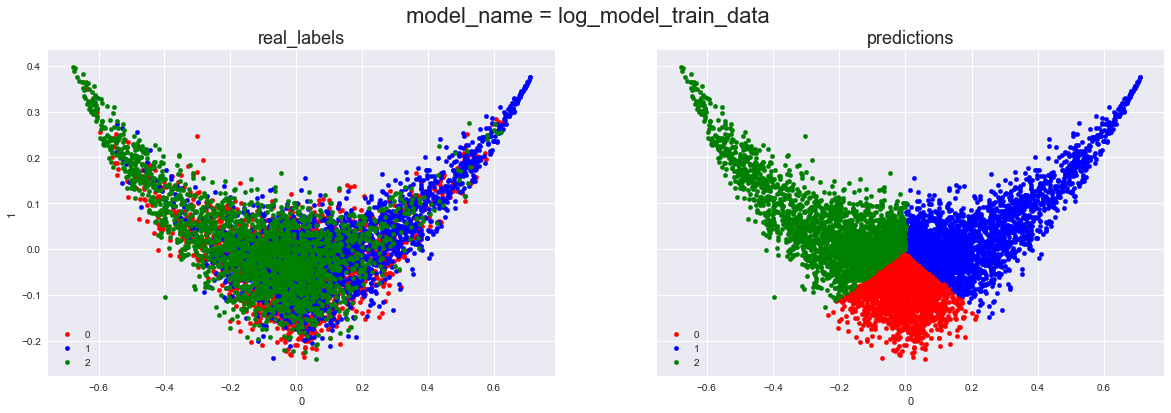

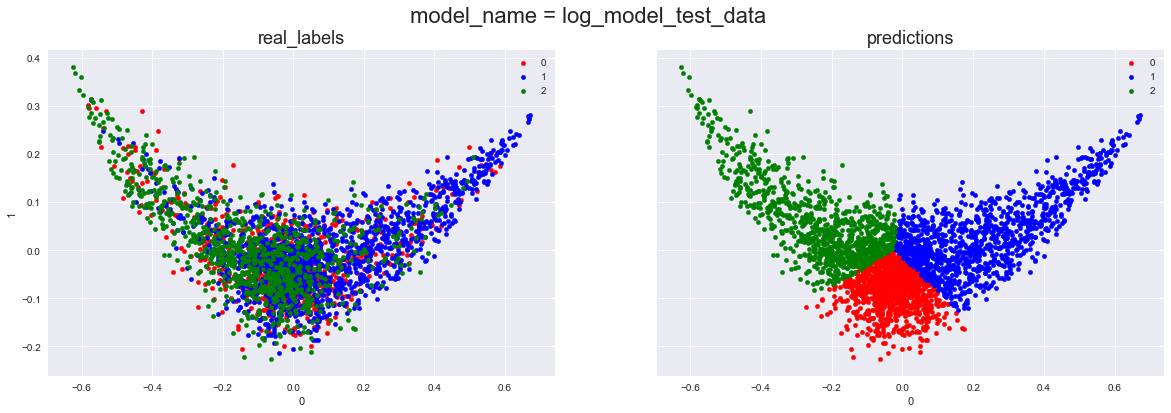

In [31]:
train_soft_decision = logmodel.predict_proba(X_train_def)
test_soft_decision  = logmodel.predict_proba(X_test_def)

plot_soft_decision_plan("log_model_train_data",train_soft_decision,y_train_original[labels_list])
plot_soft_decision_plan("log_model_test_data",test_soft_decision,y_test_original[labels_list])

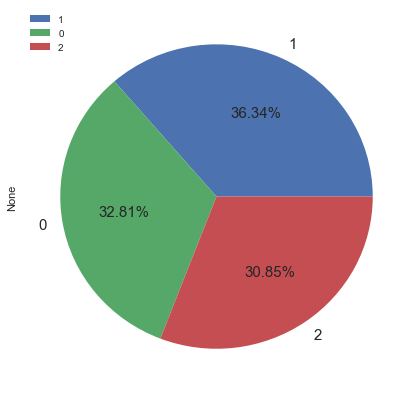

In [32]:
pd.Series(predictions).value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)

#### Adding thresold to Logistic Regression model

In [33]:
soft_decision = logmodel.predict_proba(X_test_def)

In [34]:
def thresh_1(probs,threshold):
    decision  = -1
    if max(probs) == probs[0]: decision = 0
    else:
        home_away_probs = list(probs[[1,2]])
        if max(home_away_probs) > threshold*min(home_away_probs): decision = (home_away_probs.index(max(home_away_probs)) + 1)
    if decision == -1: decision = 0
    return decision

def thresh_2(probs,threshold):
    decision  = -1
    if    probs[1] > threshold[1]: decision = 1
    elif  probs[2] > threshold[2]: decision = 2
    else:                          decision = 0
    return decision

In [35]:
new_predictions = {"threshold_1":[],"threshold_2":[]}

for aa in range(len(soft_decision)):
    new_predictions["threshold_1"].append(thresh_1(soft_decision[aa],threshold_1))
    new_predictions["threshold_2"].append(thresh_2(soft_decision[aa],threshold_2))

In [36]:
for thresh,prediction in new_predictions.items():
    printmd('**threshold = ' + thresh + '**')
    print(classification_report(y_test_def,prediction))
    print(confusion_matrix(y_test_def,prediction),"\n\n")

**threshold = threshold_2**

             precision    recall  f1-score   support

          0       0.28      0.51      0.36       755
          1       0.74      0.34      0.47      1468
          2       0.45      0.55      0.50       895

avg / total       0.55      0.44      0.45      3118

[[383 104 268]
 [643 504 321]
 [331  73 491]] 




**threshold = threshold_1**

             precision    recall  f1-score   support

          0       0.29      0.57      0.38       755
          1       0.69      0.42      0.53      1468
          2       0.53      0.42      0.47       895

avg / total       0.55      0.46      0.47      3118

[[429 165 161]
 [667 622 179]
 [408 108 379]] 




#### Adding more models:

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### KNN:

In [38]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_def,y_train_def)
    pred_i = knn.predict(X_test_def)
    error_rate.append(np.mean(pred_i != y_test_def))

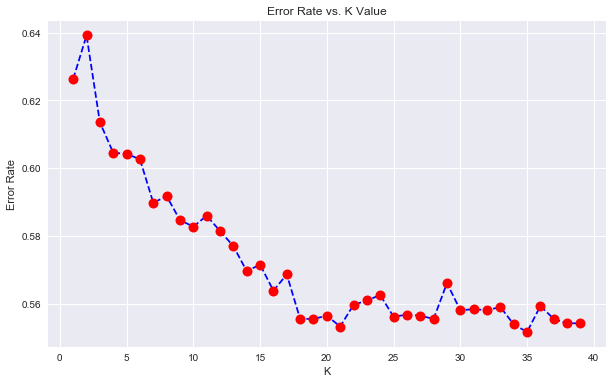

In [39]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [40]:
best_n_neighbors = error_rate.index(min(error_rate))+1
print("best_n_neighbors =",best_n_neighbors)

best_n_neighbors = 35


In [41]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)

#### SVM:

In [42]:
#svm_param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001]} 
#svm_grid   = GridSearchCV(SVC(), svm_param_grid, refit = True, verbose = 3)
#svm_grid.best_estimator_

In [43]:
svm = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
          max_iter=-1, probability=True, random_state=None, shrinking=True,
          tol=0.001, verbose=False)

#### Decision Tree:

In [44]:
#dtree_param_grid = {'max_depth': [5,6,7,8,9,10], 'min_samples_split': [6,7,8,9,10], 'min_samples_leaf': [2,3,4],'max_features':[10,20,30,40,50,None]} 
#dtree_grid   = GridSearchCV(DecisionTreeClassifier(), dtree_param_grid, refit = True, verbose = 3)
#dtree_grid.best_estimator_

In [45]:
dtree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                               max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,
                               min_samples_leaf=3, min_samples_split=9,
                               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
                               splitter='best')

#### Random Forest:

In [46]:
#rfc_param_grid = {'max_depth': [5,6,7,8,9,10], 'min_samples_split': [6,7,8,9,10], 'min_samples_leaf': [2,3,4],'max_features':[10,20,30,40,50,None]} 
#rfc_grid   = GridSearchCV(RandomForestClassifier(n_estimators=10), rfc_param_grid, refit = True, verbose = 3)
#rfc_grid.best_estimator_

In [47]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                             max_depth=6, max_features='auto', max_leaf_nodes=None,
                             min_impurity_split=1e-07, min_samples_leaf=4,
                             min_samples_split=6, min_weight_fraction_leaf=0.0,
                             n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
                             verbose=0, warm_start=False)

# rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                              max_depth=5, max_features=10, max_leaf_nodes=None,
#                              min_impurity_split=1e-07, min_samples_leaf=4,
#                              min_samples_split=8, min_weight_fraction_leaf=0.0,
#                              n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
#                              verbose=0, warm_start=False)

#### Train and Predict using all model:

In [48]:
all_models               = [knn,rfc,dtree,svm]

models_test_predictions  = {}
models_train_predictions = {}

for model in all_models:
    classifier_name = str(model).split("(")[0]
    model.fit(X_train_def,y_train_def)
    models_test_predictions[classifier_name]  = model.predict(X_test_def)
    models_train_predictions[classifier_name] = model.predict(X_train_def)

KNeighborsClassifier
RandomForestClassifier
DecisionTreeClassifier
SVC


In [49]:
printmd('**Test Data:**')

for model_name,model_prediction in models_test_predictions.items():
    printmd('**classifier = ' + model_name + '**')
    print(classification_report(y_test_def,model_prediction))
    print(confusion_matrix(y_test_def,model_prediction),"\n\n")

**Test Data:**

**classifier = RandomForestClassifier**

             precision    recall  f1-score   support

          0       0.29      0.40      0.33       755
          1       0.66      0.50      0.57      1468
          2       0.49      0.52      0.50       895

avg / total       0.52      0.48      0.49      3118

[[302 220 233]
 [475 731 262]
 [277 151 467]] 




**classifier = DecisionTreeClassifier**

             precision    recall  f1-score   support

          0       0.29      0.48      0.36       755
          1       0.67      0.47      0.56      1468
          2       0.50      0.46      0.48       895

avg / total       0.53      0.47      0.49      3118

[[363 199 193]
 [555 697 216]
 [339 142 414]] 




**classifier = KNeighborsClassifier**

             precision    recall  f1-score   support

          0       0.27      0.41      0.33       755
          1       0.64      0.45      0.53      1468
          2       0.45      0.47      0.46       895

avg / total       0.49      0.45      0.46      3118

[[306 211 238]
 [513 667 288]
 [301 169 425]] 




**classifier = SVC**

             precision    recall  f1-score   support

          0       0.28      0.45      0.35       755
          1       0.67      0.46      0.55      1468
          2       0.48      0.49      0.49       895

avg / total       0.52      0.47      0.48      3118

[[343 195 217]
 [541 675 252]
 [320 136 439]] 




In [50]:
printmd('**Train Data:**')

for model_name,model_prediction in models_train_predictions.items():
    printmd('**classifier = ' + model_name + '**')
    print(classification_report(y_train_def,model_prediction))
    print(confusion_matrix(y_train_def,model_prediction),"\n\n")

**Train Data:**

**classifier = RandomForestClassifier**

             precision    recall  f1-score   support

          0       0.48      0.50      0.49      2351
          1       0.57      0.55      0.56      2351
          2       0.57      0.57      0.57      2351

avg / total       0.54      0.54      0.54      7053

[[1186  580  585]
 [ 654 1291  406]
 [ 633  378 1340]] 




**classifier = DecisionTreeClassifier**

             precision    recall  f1-score   support

          0       0.40      0.51      0.45      2351
          1       0.54      0.50      0.52      2351
          2       0.57      0.47      0.52      2351

avg / total       0.51      0.49      0.49      7053

[[1201  618  532]
 [ 899 1168  284]
 [ 888  363 1100]] 




**classifier = KNeighborsClassifier**

             precision    recall  f1-score   support

          0       0.44      0.48      0.46      2351
          1       0.53      0.49      0.51      2351
          2       0.52      0.51      0.51      2351

avg / total       0.49      0.49      0.49      7053

[[1121  594  636]
 [ 727 1161  463]
 [ 724  439 1188]] 




**classifier = SVC**

             precision    recall  f1-score   support

          0       0.44      0.51      0.47      2351
          1       0.57      0.51      0.54      2351
          2       0.56      0.53      0.54      2351

avg / total       0.52      0.52      0.52      7053

[[1197  561  593]
 [ 759 1208  384]
 [ 770  337 1244]] 




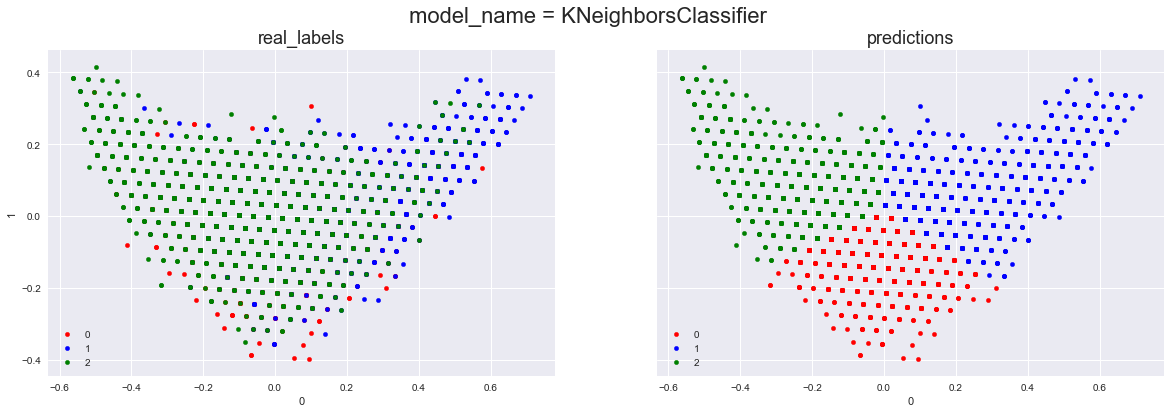

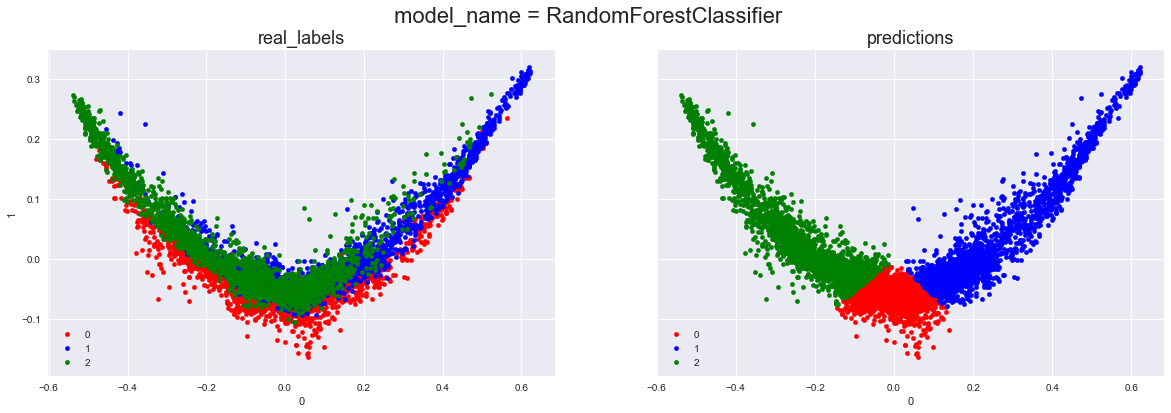

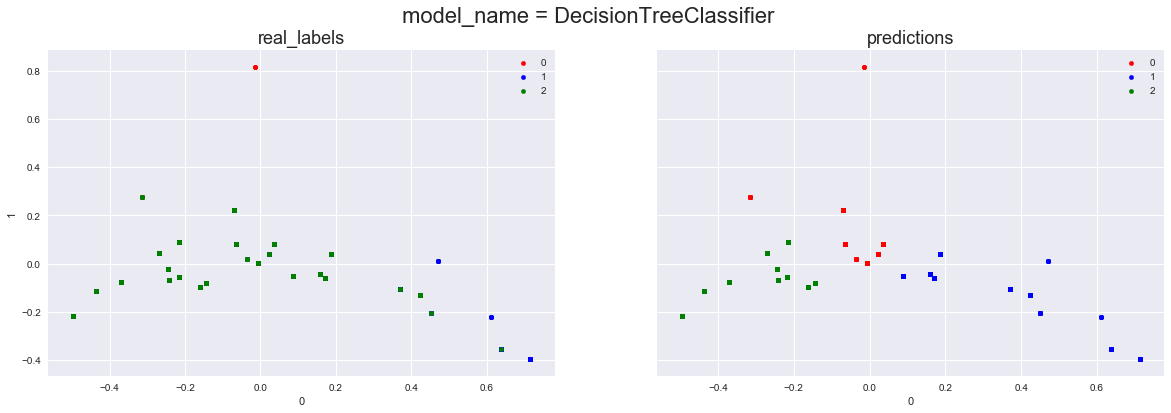

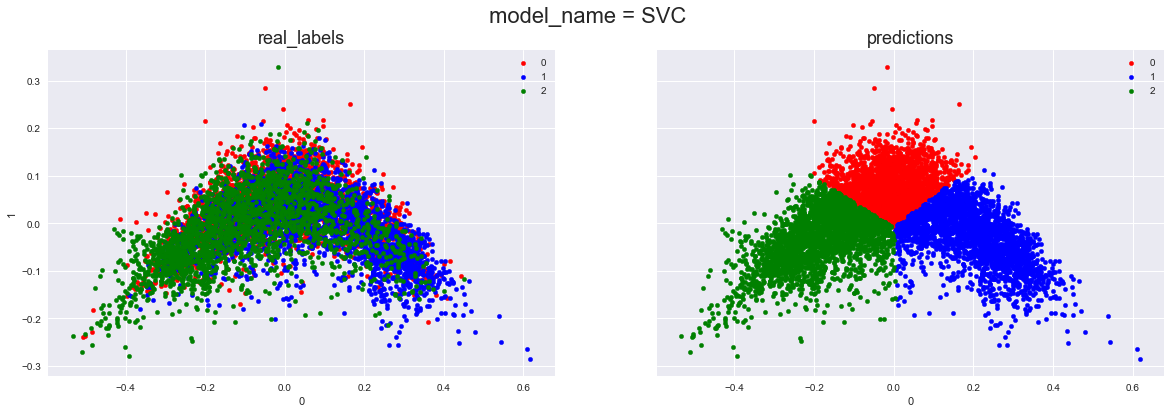

In [51]:
for model in all_models:
    classifier_name = str(model).split("(")[0]
    aaa = model.predict_proba(X_train_def)
    plot_soft_decision_plan(classifier_name,aaa,y_train_original[labels_list])

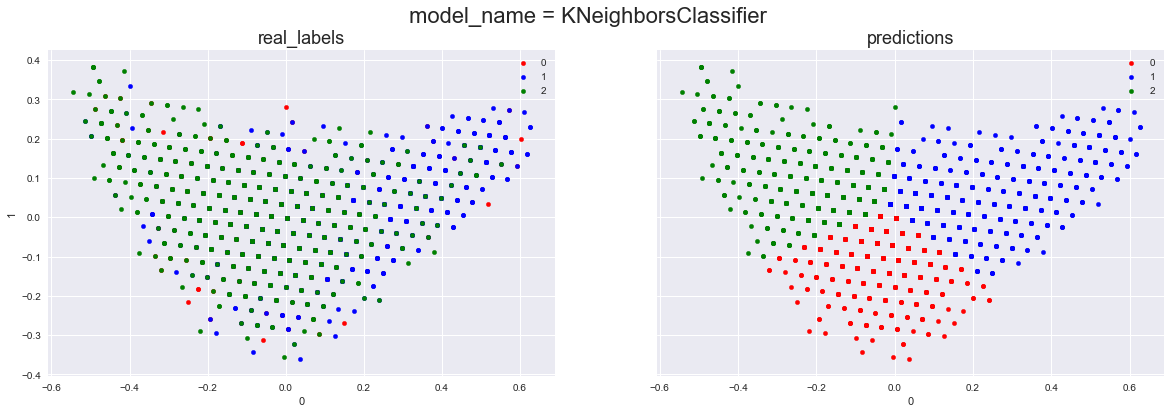

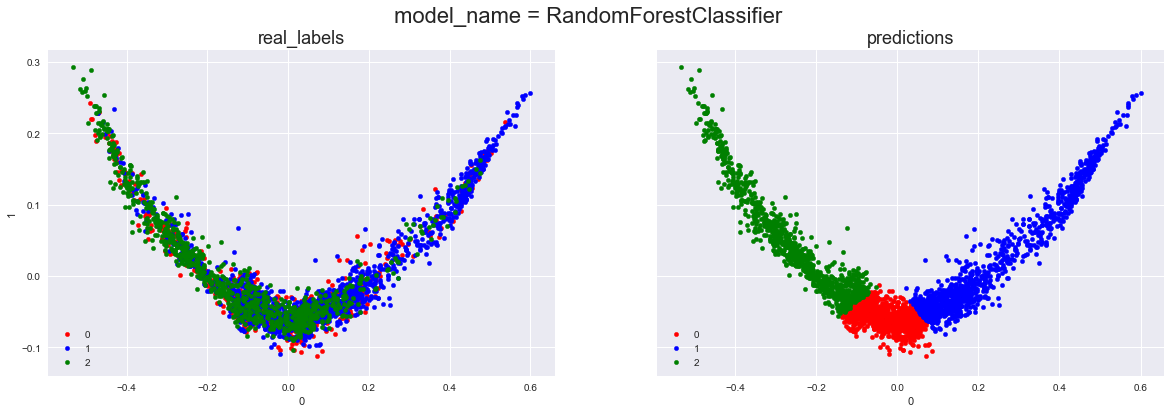

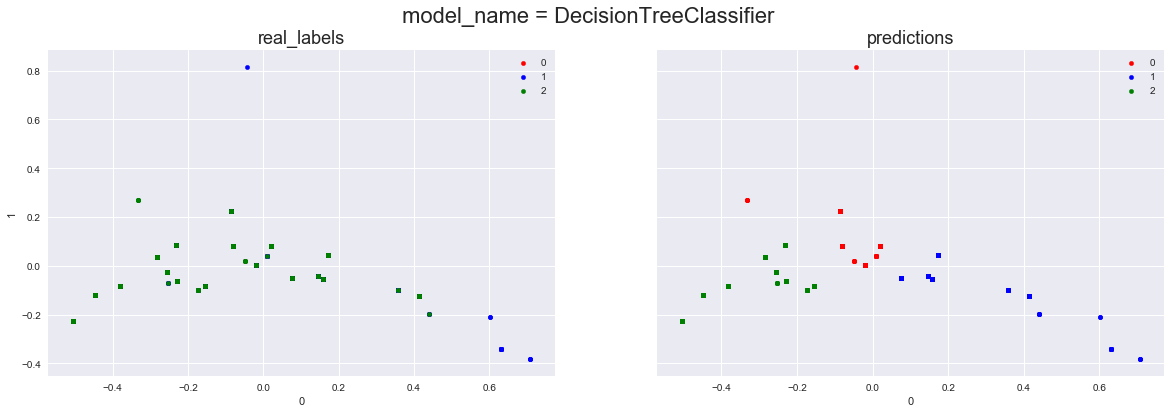

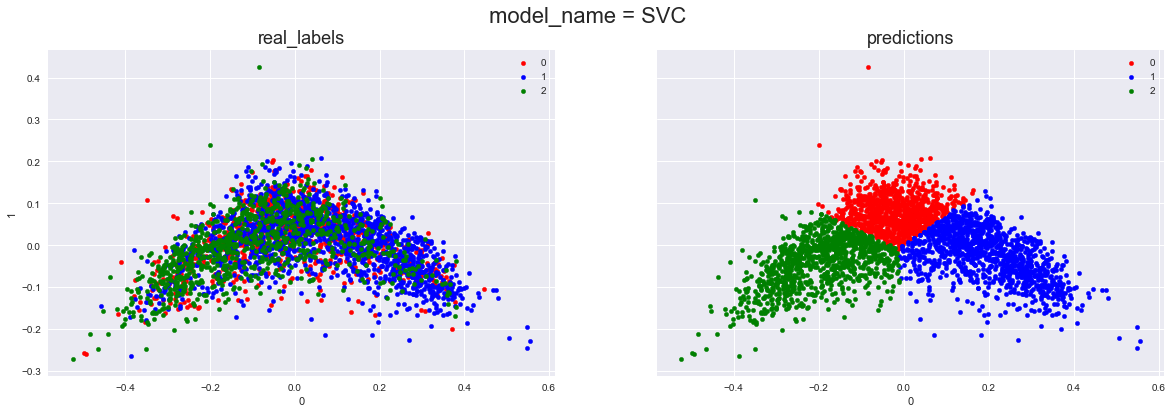

In [52]:
for model in all_models:
    classifier_name = str(model).split("(")[0]
    aaa = model.predict_proba(X_test_def)
    plot_soft_decision_plan(classifier_name,aaa,y_test_original[labels_list])

#### Nueral Network model

In [53]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
from keras import regularizers
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

Using TensorFlow backend.


In [54]:
L   = [100,100,10]
dim = len(features_list)
k   = 3

nb_epoch   = 150
batch_size = 1500
dropout    = 0.5
regularization_factor = 0.01

X_train_mat = X_train_def.as_matrix()
X_test_mat  = X_test_def.as_matrix()
y_train_mat = y_train_def.as_matrix()
y_test_mat  = y_test_def.as_matrix()
Y_train_mat = np_utils.to_categorical(y_train_def, k)
Y_test_mat  = np_utils.to_categorical(y_test_def, k)

In [55]:
# normalizer = preprocessing.Normalizer().fit(X_train)
# X_train_norm = normalizer.transform(X_train)                            
# X_test_norm = normalizer.transform(X_test)    
X_train_mat.max()

117.0

In [56]:
nn_model = Sequential()
nn_model.add(Dense(L[0], input_dim=dim, init='normal', activation='relu'))
nn_model.add(Dropout(dropout))
for ii in range(1,len(L)):
    nn_model.add(Dense(L[ii], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu'))
    nn_model.add(Dropout(dropout))
nn_model.add(Dense(k, init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='softmax'))
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="normal", input_dim=69)`
  
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  """
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  """
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="softmax", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  import sys


In [57]:
nn_model.fit(X_train_mat, Y_train_mat, nb_epoch=nb_epoch, batch_size=batch_size,validation_data=(X_test_mat, Y_test_mat),shuffle=True, callbacks=[early_stopping])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 7053 samples, validate on 3118 samples
Epoch 1/150
7053/7053 [==============================] - 4s - loss: 1.3641 - categorical_accuracy: 0.3414 - val_loss: 1.3347 - val_categorical_accuracy: 0.5180
Epoch 2/150
7053/7053 [==============================] - 0s - loss: 1.3275 - categorical_accuracy: 0.3601 - val_loss: 1.2979 - val_categorical_accuracy: 0.5244
Epoch 3/150
7053/7053 [==============================] - 0s - loss: 1.2908 - categorical_accuracy: 0.3888 - val_loss: 1.2637 - val_categorical_accuracy: 0.5055
Epoch 4/150
7053/7053 [==============================] - 0s - loss: 1.2562 - categorical_accuracy: 0.3956 - val_loss: 1.2321 - val_categorical_accuracy: 0.4881
Epoch 5/150
7053/7053 [==============================] - 0s - loss: 1.2253 - categorical_accuracy: 0.4103 - val_loss: 1.2000 - val_categorical_accuracy: 0.4958
Epoch 6/150
7053/7053 [==============================] - 0s - loss: 1.2028 - categorical_accuracy: 0.4137 - val_loss: 1.1694 - val_categorical_accuracy:

In [58]:
final_predictions = nn_model.predict_classes(X_test_mat, verbose=1)
print(classification_report(y_test_mat,final_predictions))
print(confusion_matrix(y_test_mat,final_predictions))

2464/3118 [======================>.......] - ETA: 0s             precision    recall  f1-score   support

          0       0.28      0.26      0.27       755
          1       0.64      0.53      0.58      1468
          2       0.45      0.60      0.52       895

avg / total       0.50      0.49      0.49      3118

[[199 263 293]
 [324 781 363]
 [178 177 540]]


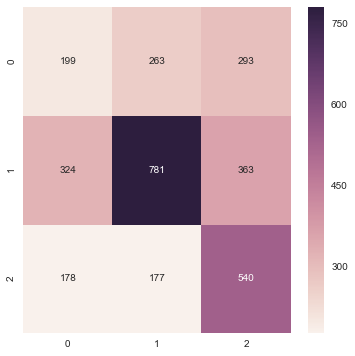

In [59]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_mat,final_predictions),annot=True, fmt="d")

### LSTM

In [60]:
def func1(x,temp_dic,home_away,team):
    temp_dic[home_away]              = x.loc[(x[home_away + "_team_name"] == team)].copy()
    temp_dic[home_away]["home_away"] = home_away
    
def get_df(x,func,func_data):
    temp_dic = {}
    for home_away in ["home", "away"]:
        func(x,temp_dic,home_away,func_data)
    return temp_dic["home"].append(temp_dic["away"]).sort_values(["season","stage"])

In [61]:
new_matches_LSTM = final_matches_db
all_teams_LSTM = final_matches_db["home_team_name"].unique()
all_seasons_LSTM = final_matches_db['season'].unique()

In [62]:
all_leagues

array(['England Premier League', 'France Ligue 1', 'Germany 1. Bundesliga',
       'Netherlands Eredivisie', 'Spain LIGA BBVA'], dtype=object)

In [63]:
tested_league = ['Netherlands Eredivisie']

In [64]:
new_matches_LSTM.dropna(inplace=True)
num_total = []
for league in all_leagues:
    min_stage = new_matches_LSTM[new_matches_LSTM["league"] == league]["stage"].min()
    max_stage = new_matches_LSTM[new_matches_LSTM["league"] == league]["stage"].max()
    print("league =",league,", min_stage =",min_stage,", max_stage =",max_stage)
    num_of_stages    = max_stage - min_stage + 1
    num_total.append(num_of_stages)
num_total
max_stages = np.max(num_total)
num_of_features = len(features_list)

league = England Premier League , min_stage = 5 , max_stage = 38
league = France Ligue 1 , min_stage = 5 , max_stage = 38
league = Germany 1. Bundesliga , min_stage = 5 , max_stage = 34
league = Netherlands Eredivisie , min_stage = 5 , max_stage = 34
league = Spain LIGA BBVA , min_stage = 5 , max_stage = 38


In [65]:
np.zeros([1,2,2])

array([[[ 0.,  0.],
        [ 0.,  0.]]])

In [66]:
new_matches_LSTM

,index,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
40,40,England Premier League,2008/2009,5,Liverpool,Stoke City,0 - 0,10.0,1.000000,2.0,...,1.20,1.20,1.20,15.00,15.00,17.00,6.50,6.00,6.50,0
41,41,England Premier League,2008/2009,5,Sunderland,Middlesbrough,2 - 0,4.0,0.400000,17.0,...,2.38,2.30,2.25,3.20,3.20,3.35,3.10,3.20,3.30,1
42,42,England Premier League,2008/2009,5,Tottenham Hotspur,Wigan Athletic,0 - 0,1.0,0.100000,20.0,...,1.73,1.70,1.70,5.00,5.50,5.50,3.60,3.40,3.60,0
43,43,England Premier League,2008/2009,5,West Ham United,Newcastle United,3 - 1,6.0,0.600000,8.0,...,2.10,2.00,2.00,3.60,3.80,3.80,3.30,3.30,3.50,1
44,44,England Premier League,2008/2009,5,Manchester City,Portsmouth,6 - 0,6.0,0.600000,7.0,...,2.00,2.00,2.05,4.00,3.80,3.80,3.30,3.30,3.35,1
45,45,England Premier League,2008/2009,5,Blackburn Rovers,Fulham,1 - 0,4.0,0.400000,18.0,...,2.10,2.10,2.05,3.60,3.50,3.75,3.30,3.30,3.40,1
46,46,England Premier League,2008/2009,5,Bolton Wanderers,Arsenal,1 - 3,4.0,0.400000,14.0,...,6.50,6.00,6.20,1.57,1.62,1.60,3.75,3.60,3.80,2
47,47,England Premier League,2008/2009,5,West Bromwich Albion,Aston Villa,1 - 2,4.0,0.400000,15.0,...,3.25,2.90,3.30,2.25,2.40,2.25,3.30,3.30,3.35,2
48,48,England Premier League,2008/2009,5,Hull City,Everton,2 - 2,7.0,0.700000,6.0,...,3.10,3.25,3.15,2.30,2.25,2.30,3.40,3.25,3.40,0
49,49,England Premier League,2008/2009,5,Chelsea,Manchester United,1 - 1,10.0,1.000000,1.0,...,2.20,2.20,2.20,3.60,3.60,3.70,3.10,3.00,3.10,0


In [67]:
new_matches_LSTM.columns

Index(['index', 'league', 'season', 'stage', 'home_team_name',
       'away_team_name', 'score', 'home_points', 'home_norm_points',
       'home_position', 'home_straight_wins', 'home_straight_loses',
       'home_straight_draws', 'home_tot_pos_goals', 'home_tot_neg_goals',
       'home_goals_diff', 'home_1_last_wld', 'home_2_last_wld',
       'home_3_last_wld', 'home_4_last_wld', 'home_2_pos_goals',
       'home_3_pos_goals', 'home_4_pos_goals', 'home_2_neg_goals',
       'home_3_neg_goals', 'home_4_neg_goals', 'home_2_wins', 'home_3_wins',
       'home_4_wins', 'home_2_loses', 'home_3_loses', 'home_4_loses',
       'home_2_draws', 'home_3_draws', 'home_4_draws', 'away_points',
       'away_norm_points', 'away_position', 'away_straight_wins',
       'away_straight_loses', 'away_straight_draws', 'away_tot_pos_goals',
       'away_tot_neg_goals', 'away_goals_diff', 'away_1_last_wld',
       'away_2_last_wld', 'away_3_last_wld', 'away_4_last_wld',
       'away_2_pos_goals', 'away_3_pos_g

In [68]:
def LSTM_matrix_league_pad(matches_LSTM,all_leagues,all_teams_LSTM,all_seasons_LSTM):
    label_league = {}
    LSTM_matches_league = {}
    index_league = {}
    min_stage = float('inf')

    first_iter = True
    for league in all_leagues:
        for team in all_teams_LSTM:
            for season in all_seasons_LSTM:
                matches_per_team        = get_df(matches_LSTM[matches_LSTM['league']==league],func1,team)
                matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
                if len(matches_per_team_season.index) == 0: continue
                temp = matches_per_team_season.dropna(axis = 0)

                matches_temp = temp['index'].as_matrix()
                matches_temp = np.expand_dims(matches_temp, axis=0)

                labels_temp = temp['win_lose_draw'].as_matrix()
                labels_temp_bin = np_utils.to_categorical(labels_temp, k)
                labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)

                features_temp = temp[features_list] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
                matches_per_team_season_mat = features_temp.as_matrix()
                matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)

                if first_iter:
                    if np.shape(matches_per_team_season_mat)[1] != max_stages:
                        
                        columns_to_fill = max_stages - np.shape(matches_per_team_season_mat)[1]
                        features_pad = np.zeros([1,columns_to_fill,num_of_features])
                        matches_per_team_season_mat = np.concatenate((matches_per_team_season_mat,features_pad),axis = 1)

                        label_pad = np.zeros([1,columns_to_fill])
                        label_pad = np_utils.to_categorical(label_pad, k)
                        label_pad = np.expand_dims(label_pad, axis=0)
                        labels_temp_bin = np.concatenate((labels_temp_bin,label_pad),axis = 1)
                        
                        index_pad = np.ones([1,columns_to_fill])*(-1)
                        matches_temp = np.concatenate((matches_temp,index_pad),axis = 1)
                        
                    label_league[league] = labels_temp_bin
                    LSTM_matches_league[league] = matches_per_team_season_mat
                    index_league[league] = matches_temp
                    first_iter = False

                else:
                    if np.shape(matches_per_team_season_mat)[1] != max_stages:
                        columns_to_fill = max_stages - np.shape(matches_per_team_season_mat)[1]
                        features_pad = np.zeros([1,columns_to_fill,num_of_features])
                        matches_per_team_season_mat = np.concatenate((matches_per_team_season_mat,features_pad),axis = 1)
                        
                        label_pad = np.zeros([1,columns_to_fill])
                        label_pad = np_utils.to_categorical(label_pad, k)
                        label_pad = np.expand_dims(label_pad, axis=0)
                        labels_temp_bin = np.concatenate((labels_temp_bin,label_pad),axis = 1)
                        
                        index_pad = np.ones([1,columns_to_fill])*(-1)
                        matches_temp = np.concatenate((matches_temp,index_pad),axis = 1)
                    
                    LSTM_matches_league[league] = np.concatenate((LSTM_matches_league[league], matches_per_team_season_mat), axis=0)
                    label_league[league] = np.concatenate((label_league[league], labels_temp_bin), axis=0)
                    index_league[league] = np.concatenate((index_league[league], matches_temp), axis=0)
        print(league,np.shape(LSTM_matches_league[league]))
        min_stage = min(min_stage,np.shape(LSTM_matches_league[league])[1])
        first_iter = True
        
    return (LSTM_matches_league,label_league,index_league,min_stage)

In [69]:
train_matches = pd.concat([X_train_original,y_train_original['win_lose_draw']], axis=1)
test_matches = pd.concat([X_test_original,y_test_original['win_lose_draw']], axis=1)
LSTM_matches_league_train_pad,label_league_train_pad,index_league_train_pad,min_stage_train_pad = LSTM_matrix_league_pad(train_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)
LSTM_matches_league_test_pad,label_league_test_pad,index_league_test_pad,min_stage_test_pad = LSTM_matrix_league_pad(test_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)

England Premier League (120, 34, 69)
France Ligue 1 (120, 34, 69)
Germany 1. Bundesliga (108, 34, 69)
Netherlands Eredivisie (108, 34, 69)
Spain LIGA BBVA (120, 34, 69)
England Premier League (40, 34, 69)
France Ligue 1 (40, 34, 69)
Germany 1. Bundesliga (36, 34, 69)
Netherlands Eredivisie (36, 34, 69)
Spain LIGA BBVA (40, 34, 69)


In [70]:
def LSTM_matrix_league(matches_LSTM,all_leagues,all_teams_LSTM,all_seasons_LSTM):
    label_league = {}
    LSTM_matches_league = {}
    index_league = {}
    min_stage = float('inf')

    first_iter = True
    for league in all_leagues:
        for team in all_teams_LSTM:
            for season in all_seasons_LSTM:
                matches_per_team        = get_df(matches_LSTM[matches_LSTM['league']==league],func1,team)
                matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
#                 print(matches_per_team_season)
#                 return
                if len(matches_per_team_season.index) == 0: continue
                temp = matches_per_team_season.dropna(axis = 0)

                matches_temp = temp['index'].as_matrix()
                matches_temp = np.expand_dims(matches_temp, axis=0)

                labels_temp = temp['win_lose_draw'].as_matrix()
                labels_temp_bin = np_utils.to_categorical(labels_temp, k)
                labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)

                features_temp = temp[features_list] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
                matches_per_team_season_mat = features_temp.as_matrix()
                matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)
#                 print(matches_per_team_season_mat.shape[1])
                
                if first_iter:
                    label_league[league] = labels_temp_bin
                    LSTM_matches_league[league] = matches_per_team_season_mat
                    index_league[league] = matches_temp
                    first_iter = False
                    current_stage_num = np.shape(LSTM_matches_league[league])[1]
                else:
                    if np.shape(matches_per_team_season_mat)[1] != current_stage_num:
                        continue
                    LSTM_matches_league[league] = np.concatenate((LSTM_matches_league[league], matches_per_team_season_mat), axis=0)
                    label_league[league] = np.concatenate((label_league[league], labels_temp_bin), axis=0)
                    index_league[league] = np.concatenate((index_league[league], matches_temp), axis=0)
        print(league,np.shape(LSTM_matches_league[league]))
        min_stage = min(min_stage,np.shape(LSTM_matches_league[league])[1])
        first_iter = True
        
    return (LSTM_matches_league,label_league,index_league,min_stage)

In [71]:
train_matches = pd.concat([X_train_original,y_train_original['win_lose_draw']], axis=1)
test_matches = pd.concat([X_test_original,y_test_original['win_lose_draw']], axis=1)
LSTM_matches_league_train,label_league_train,index_league_train,min_stage_train = LSTM_matrix_league(train_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)
LSTM_matches_league_test,label_league_test,index_league_test,min_stage_test = LSTM_matrix_league(test_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)

England Premier League (8, 29, 69)
France Ligue 1 (20, 26, 69)
Germany 1. Bundesliga (20, 24, 69)
Netherlands Eredivisie (20, 23, 69)
Spain LIGA BBVA (17, 23, 69)
England Premier League (40, 34, 69)
France Ligue 1 (38, 34, 69)
Germany 1. Bundesliga (36, 30, 69)
Netherlands Eredivisie (34, 30, 69)
Spain LIGA BBVA (40, 34, 69)


In [72]:
# LSTM_matches_league_test,label_league_test,index_league_test = LSTM_matrix_league(new_matches_LSTM,all_leagues,all_teams_LSTM,all_seasons_LSTM)

In [73]:
# Y_train_league = {}
# LSTM_matches_league = {}
# Matches_id_league = {}
# min_stage = float('inf')

# first_iter = True
# for league in all_leagues:
#     for team in all_teams_LSTM:
#         for season in all_seasons_LSTM:
#             matches_per_team        = get_df(new_matches_LSTM[new_matches_LSTM['league']==league],func1,team)
#             matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
#             if len(matches_per_team_season.index) == 0: continue
#             temp = matches_per_team_season.dropna(axis = 0)

#             matches_temp = temp['index'].as_matrix()
#             matches_temp = np.expand_dims(matches_temp, axis=0)
            
#             labels_temp = temp['win_lose_draw'].as_matrix()
#             labels_temp_bin = np_utils.to_categorical(labels_temp, k)
#             labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)

#             features_temp = temp[new_new_columns] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
#             matches_per_team_season_mat = features_temp.as_matrix()
#             matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)

#             if first_iter:
#                 Y_train_league[league] = labels_temp_bin
#                 LSTM_matches_league[league] = matches_per_team_season_mat
#                 Matches_id_league[league] = matches_temp
#                 first_iter = False
#                 current_stage_num = np.shape(LSTM_matches_league[league])[1]
#             else:
#                 if np.shape(matches_per_team_season_mat)[1] != current_stage_num:
# #                     print(np.shape(matches_per_team_season_mat)[1])
#                     continue
#                 LSTM_matches_league[league] = np.concatenate((LSTM_matches_league[league], matches_per_team_season_mat), axis=0)
#                 Y_train_league[league] = np.concatenate((Y_train_league[league], labels_temp_bin), axis=0)
#                 Matches_id_league[league] = np.concatenate((Matches_id_league[league], matches_temp), axis=0)
                
#     print(league,np.shape(LSTM_matches_league[league]))
#     min_stage = min(min_stage,np.shape(LSTM_matches_league[league])[1])
#     first_iter = True

In [74]:
def LSTM_matrix(LSTM_matches_league,label_league,index_league,min_stage,all_leagues ):
    first_iter = True
    for league in all_leagues:
        if first_iter:
            labels = label_league[league][:,0:min_stage,:]
            LSTM_matches = LSTM_matches_league[league][:,0:min_stage,:]
            indexs = index_league[league][:,0:min_stage]
            first_iter = False
        else:
            LSTM_matches = np.concatenate((LSTM_matches, LSTM_matches_league[league][:,0:min_stage,:]), axis=0)
            labels = np.concatenate((labels,  label_league[league][:,0:min_stage,:]), axis=0)
            indexs = np.concatenate((indexs,  index_league[league][:,0:min_stage]), axis=0)
    return (LSTM_matches,labels,indexs)

In [75]:
pad_flag = True 
if pad_flag:    
    X_train,y_train,index_train = LSTM_matrix(LSTM_matches_league_train_pad,label_league_train_pad,index_league_train_pad,min_stage_train_pad,all_leagues)
    X_test,y_test,index_test = LSTM_matrix(LSTM_matches_league_test_pad,label_league_test_pad,index_league_test_pad,min_stage_test_pad,all_leagues)
else:
    X_train,y_train,index_train = LSTM_matrix(LSTM_matches_league_train,label_league_train,index_league_train,min_stage_train,all_leagues)
    X_test,y_test,index_test = LSTM_matrix(LSTM_matches_league_test,label_league_test,index_league_test,min_stage_test,all_leagues)

In [76]:
print(X_train.shape,y_train.shape,index_train.shape,X_test.shape,y_test.shape,index_test.shape)

(576, 34, 69) (576, 34, 3) (576, 34) (192, 34, 69) (192, 34, 3) (192, 34)


In [77]:
# first_iter = True
# for league in all_leagues:
#     if first_iter:
#         Y_train = Y_train_league[league][:,0:min_stage,:]
#         LSTM_matches = LSTM_matches_league[league][:,0:min_stage,:]
#         Matches_id = Matches_id_league[league][:,0:min_stage]
#         first_iter = False
#     else:
#         LSTM_matches = np.concatenate((LSTM_matches, LSTM_matches_league[league][:,0:min_stage,:]), axis=0)
#         Y_train = np.concatenate((Y_train,  Y_train_league[league][:,0:min_stage,:]), axis=0)
#         Matches_id = np.concatenate((Matches_id,  Matches_id_league[league][:,0:min_stage]), axis=0)

In [78]:
# first_iter = True
# for team in all_teams_LSTM:
#     for season in all_seasons_LSTM:
#         matches_per_team        = get_df(new_matches_LSTM,func1,team)
#         matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
#         if len(matches_per_team_season.index) == 0: continue
#         temp = matches_per_team_season.dropna(axis = 0)
        
#         labels_temp = temp['win_lose_draw'].as_matrix()
#         labels_temp_bin = np_utils.to_categorical(labels_temp, k)
#         labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)
        
#         features_temp = temp[new_new_columns] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
#         matches_per_team_season_mat = features_temp.as_matrix()
#         matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)
        
#         if first_iter:
#             Y_train = labels_temp_bin
#             LSTM_matches = matches_per_team_season_mat
#             first_iter = False
#         else:
#             LSTM_matches = np.concatenate((LSTM_matches, matches_per_team_season_mat), axis=0)
#             Y_train = np.concatenate((Y_train, labels_temp_bin), axis=0)
            


In [79]:
# X_train, X_test, y_train, y_test,matches_train,matches_test = train_test_split(LSTM_matches, Y_train,Matches_id, test_size=0.30, random_state=103)

In [80]:
# preprocessing
preprocessing_flag = True
if preprocessing_flag:
    x_mean = X_train.mean(axis=(0,1))
    X_train = X_train-x_mean
    x_std = X_train.std(axis=(0,1))
    X_train = X_train / x_std

In [81]:
if preprocessing_flag:
    X_test = X_test - x_mean
    X_test = X_test / x_std

In [82]:
input_shape = num_of_features
L = [128,128,64]
regularization_factor = 0.01

In [83]:
input_shape = (None,input_shape)
input_shape

(None, 69)

In [84]:
from keras import regularizers
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Masking
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

lstm_model=Sequential()
lstm_model.add(TimeDistributed(Dense(L[0], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu'),input_shape=input_shape))
lstm_model.add(TimeDistributed(Dropout(dropout)))
lstm_model.add(TimeDistributed(Dense(L[1], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu')))
lstm_model.add(Masking(mask_value=0., input_shape=(max_stages, input_shape)))
lstm_model.add(LSTM(L[2],return_sequences=True, activation='relu'))
lstm_model.add(Dense(k, init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='softmax'))

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  if __name__ == '__main__':
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="softmax", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  


In [85]:
nb_epoch = 100
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
lstm_model.fit(X_train, y_train, nb_epoch=nb_epoch,shuffle=True,validation_data=(X_test, y_test), callbacks=[early_stopping])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 576 samples, validate on 192 samples
Epoch 1/100
576/576 [==============================] - 5s - loss: 1.4510 - categorical_accuracy: 0.5196 - val_loss: 1.4935 - val_categorical_accuracy: 0.2760
Epoch 2/100
576/576 [==============================] - 3s - loss: 1.1361 - categorical_accuracy: 0.5200 - val_loss: 1.3137 - val_categorical_accuracy: 0.2819
Epoch 3/100
576/576 [==============================] - 3s - loss: 1.0012 - categorical_accuracy: 0.5218 - val_loss: 1.2118 - val_categorical_accuracy: 0.2809
Epoch 4/100
576/576 [==============================] - 3s - loss: 0.9200 - categorical_accuracy: 0.5218 - val_loss: 1.1546 - val_categorical_accuracy: 0.2806
Epoch 5/100
576/576 [==============================] - 3s - loss: 0.8728 - categorical_accuracy: 0.5269 - val_loss: 1.1177 - val_categorical_accuracy: 0.2891
Epoch 6/100
576/576 [==============================] - 3s - loss: 0.8441 - categorical_accuracy: 0.5335 - val_loss: 1.0985 - val_categorical_accuracy: 0.2963
Epoch 

In [86]:
final_predictions = lstm_model.predict_classes(X_test, verbose=1)
final_predictions_flatten = final_predictions.flatten()
y_test_flatten = y_test.argmax(axis=2).flatten()

160/192 [========================>.....] - ETA: 0s

In [87]:
print(classification_report(y_test_flatten,final_predictions_flatten))
print(confusion_matrix(y_test_flatten,final_predictions_flatten))

             precision    recall  f1-score   support

          0       0.33      0.46      0.38      1802
          1       0.46      0.03      0.05      2936
          2       0.33      0.70      0.45      1790

avg / total       0.39      0.33      0.25      6528

[[ 832   40  930]
 [1228   81 1627]
 [ 477   54 1259]]


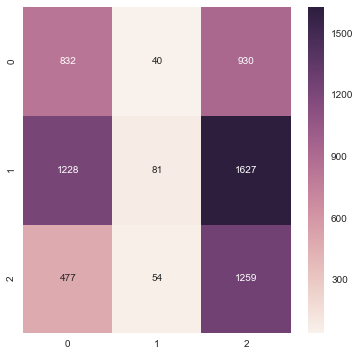

In [88]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_flatten,final_predictions_flatten),annot=True, fmt="d")

In [89]:
matches_prob = lstm_model.predict_proba(X_test)

192/192 [==============================] - 0s     


#### only test samples checking


In [90]:
total_valid_samples = 0
correct_valid_samples = 0
index_test_unique = np.unique(index_test)
index_test_unique = index_test_unique[index_test_unique != -1]
first_iter = True
index_list = []
for match_id in index_test_unique:
    matches_idxs = np.where(index_test == match_id)
    if len(matches_idxs[0])==2:
        first_team_prob = matches_prob[matches_idxs[0][0],matches_idxs[1][0],:]
        second_team_prob = matches_prob[matches_idxs[0][1],matches_idxs[1][1],:]
        mean_prob = np.mean([first_team_prob,second_team_prob],axis=0)
        if first_iter:
                mean_prob_temp = np.expand_dims(mean_prob,axis=0)
                mean_prob_mat = mean_prob_temp
                index_list.append(int(match_id))
                first_iter = False
        else:
                mean_prob_temp = np.expand_dims(mean_prob,axis=0)
                mean_prob_mat = np.concatenate((mean_prob_mat,mean_prob_temp),axis=0)
                index_list.append(int(match_id))
        label = np.where(y_test[matches_idxs[0][0],matches_idxs[1][0],:] == 1)
        prediction = mean_prob.argmax()
        if (prediction == label):
            correct_valid_samples+=1
        total_valid_samples+=1
print("{}/{}={}".format(correct_valid_samples,total_valid_samples,correct_valid_samples/total_valid_samples) )

949/3118=0.304361770365619


In [91]:
d = {'0' : pd.Series(mean_prob_mat[:,0], index=index_list),
     '1' : pd.Series(mean_prob_mat[:,1], index=index_list),
     '2' : pd.Series(mean_prob_mat[:,2], index=index_list)}
LSTM_test_matches_prob = pd.DataFrame(d)
LSTM_test_matches_prob.head()


,0,1,2
1940,0.331551,0.341374,0.327075
1941,0.298898,0.340627,0.360475
1942,0.321690,0.342644,0.335666
1943,0.306171,0.342295,0.351534
1944,0.334005,0.340989,0.325007


In [92]:
index_test_unique = np.unique(index_test)
index_test_unique = index_test_unique[index_test_unique != -1]
print(np.where(index_test_unique == -1))
index_test_unique

(array([], dtype=int64),)


array([  1940.,   1941.,   1942., ...,  11733.,  11734.,  11735.])

In [93]:
#a = matches_per_team_season2.as_matrix()
#np.shape(a)

In [94]:
#b=[[1,2,3],[4,5,6]]
#c= np.array(b)
#e=np.array([])
#e=np.expand_dims(e, axis=0)
#np.shape(c)

In [95]:
#np.concatenate((e,c),axis=0)

In [96]:
#d = np.expand_dims(c, axis=0)
#np.shape(d)

In [97]:
#x = np.ones((1, 2, 3))
#np.transpose(x, (1, 0, 2)).shape

In [98]:
#frames = [matches_per_team_season1, matches_per_team_season2]

#result = pd.concat(frames)
#result

### Save all soft decisions:

In [99]:
chosen_data  = X_test_def
soft_decision_models = [rfc,logmodel,nn_model,svm,knn,dtree]

all_soft_decisions = {"lstm_model":np.array(LSTM_test_matches_prob)}

lstm_soft_decision_df = pd.DataFrame(np.array(LSTM_test_matches_prob),index = LSTM_test_matches_prob.index,columns = ["MYD","MYH","MYA"])
lstm_soft_decision_df.to_csv("databases/my_predictions/lstm_model.csv")

for model in soft_decision_models:
    classifier_name = str(model).split("(")[0]
    if model == nn_model:
        classifier_name = "nn_model"
        
    all_soft_decisions[classifier_name] = model.predict_proba(chosen_data.as_matrix())
    
    soft_decision_df = pd.DataFrame(all_soft_decisions[classifier_name],index = chosen_data.index,columns = ["MYD","MYH","MYA"])
    
    soft_decision_df.to_csv("databases/my_predictions/" + classifier_name + ".csv")

2880/3118 [==========================>...] - ETA: 0s

#### Combine all predictions into one:

In [100]:
final_soft_decision = np.mean(list(all_soft_decisions.values()),axis=0)
final_hard_decision = final_soft_decision.argmax(axis=1)

print(classification_report(y_test_def,final_hard_decision.T))
print(confusion_matrix(y_test_def,final_hard_decision.T))

             precision    recall  f1-score   support

          0       0.29      0.38      0.33       755
          1       0.66      0.50      0.57      1468
          2       0.48      0.54      0.51       895

avg / total       0.52      0.48      0.49      3118

[[288 225 242]
 [441 739 288]
 [254 157 484]]


In [101]:
all_soft_decisions["final_soft_decision"] = final_soft_decision

soft_decision_df = pd.DataFrame(final_soft_decision,index = chosen_data.index,columns = ["MYD","MYH","MYA"])

soft_decision_df.to_csv("databases/my_predictions/final_soft_decision.csv")

### Some visualizations:

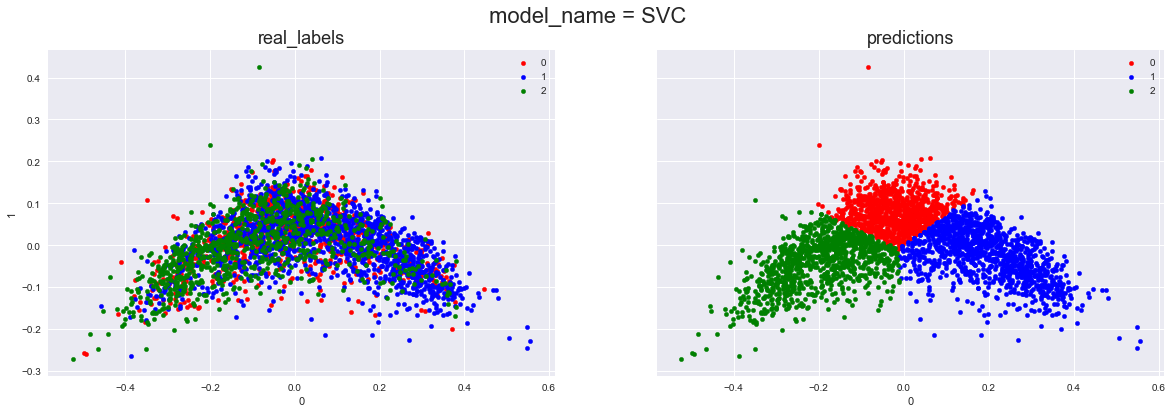

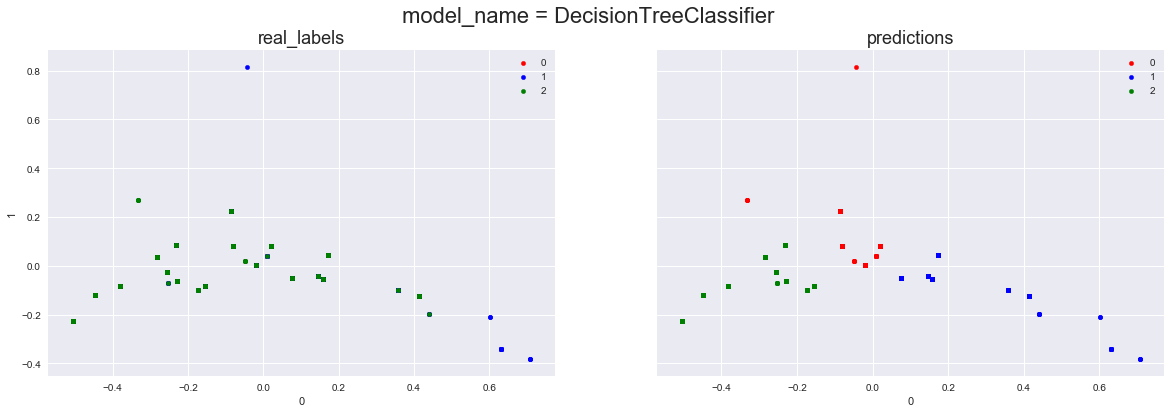

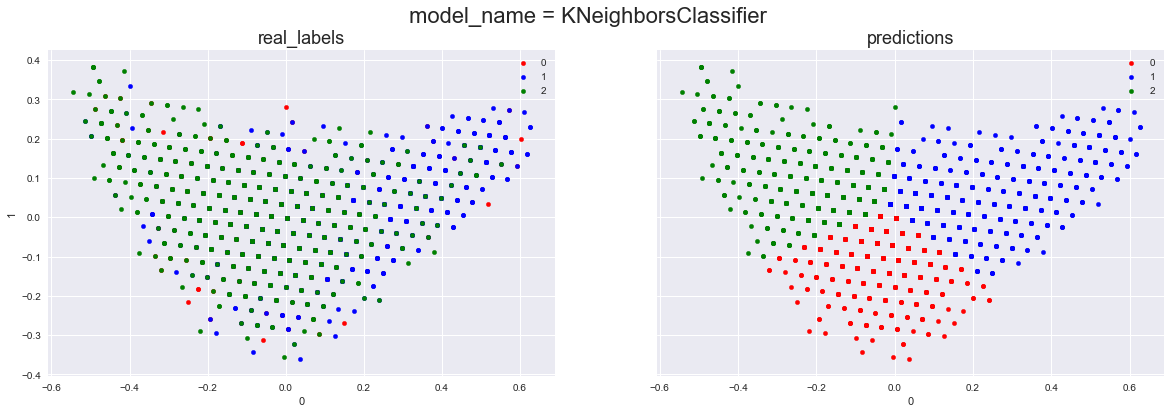

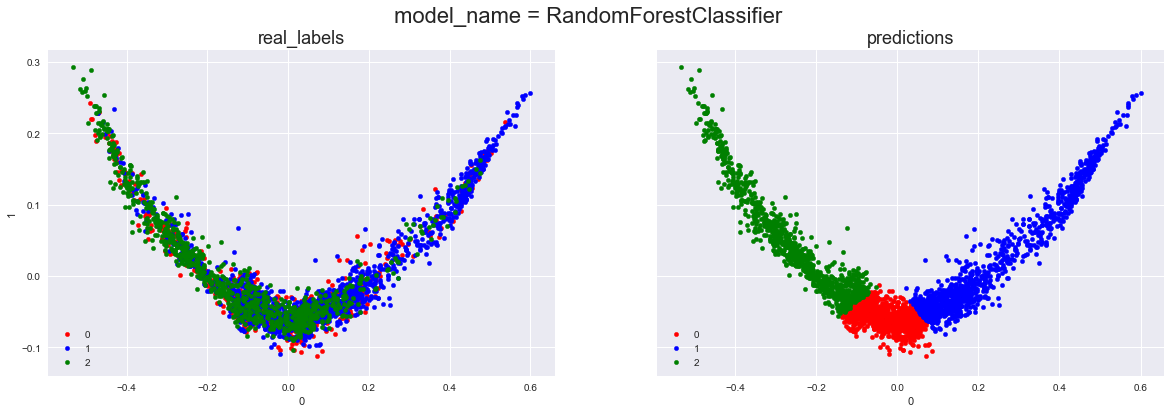

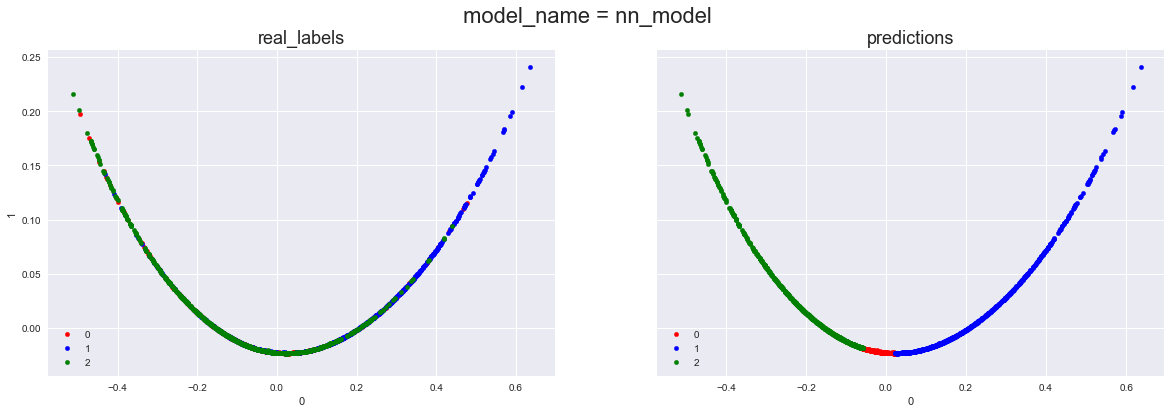

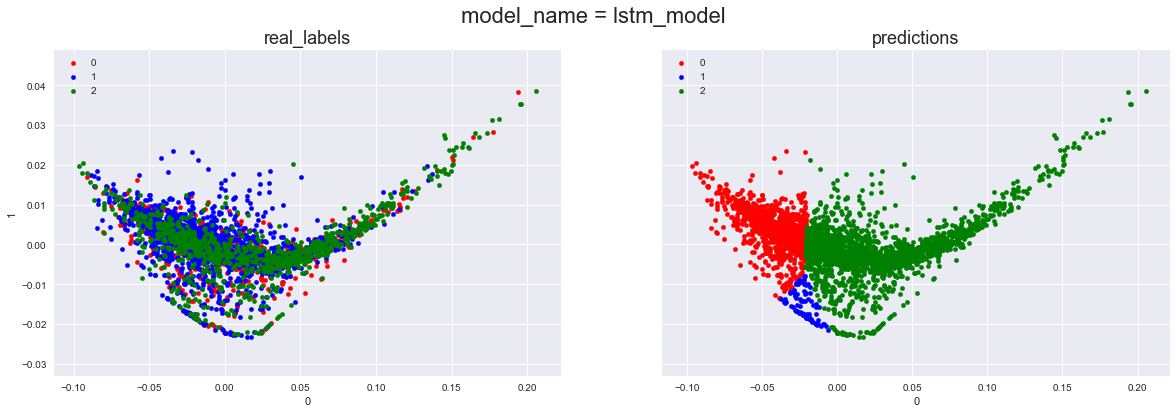

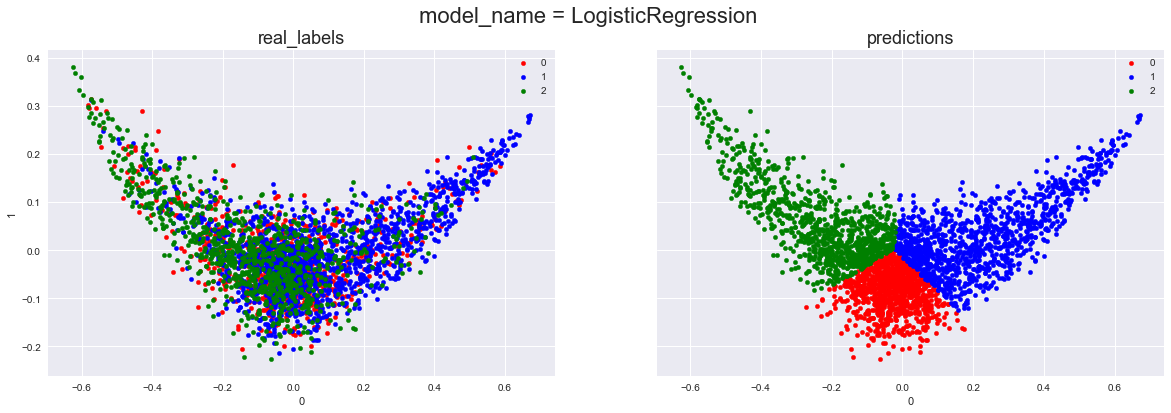

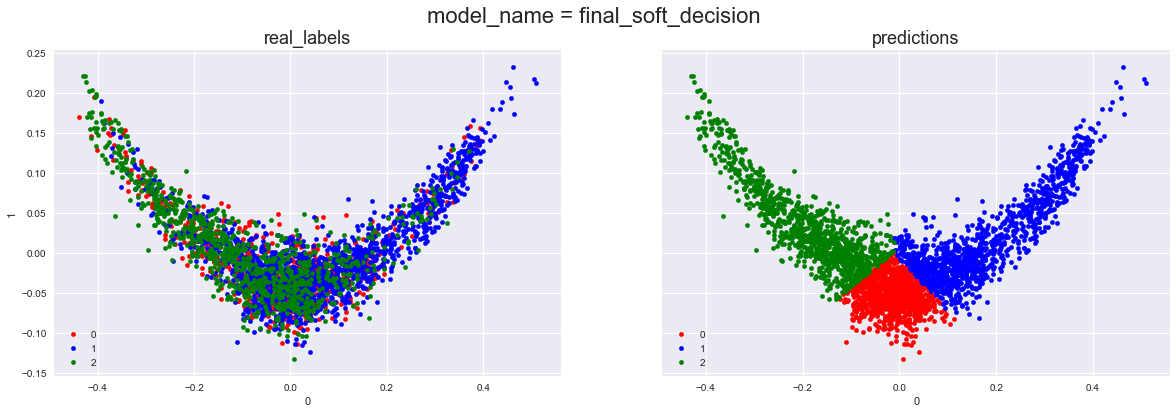

In [102]:
for model_name,model_predictions in all_soft_decisions.items():
    plot_soft_decision_plan(model_name,model_predictions,y_test_original[labels_list])

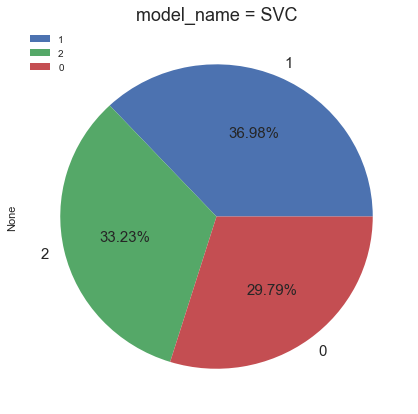

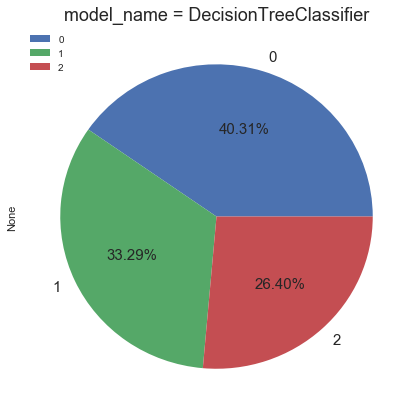

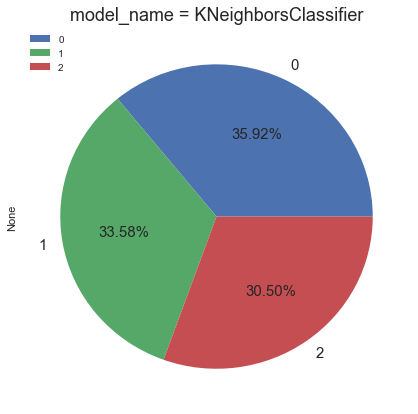

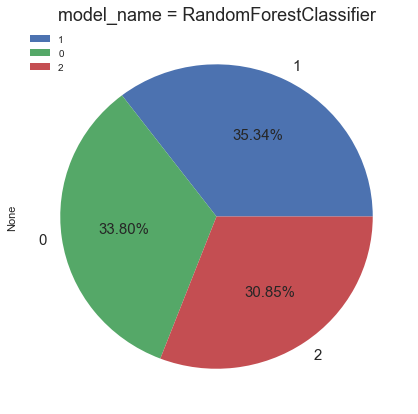

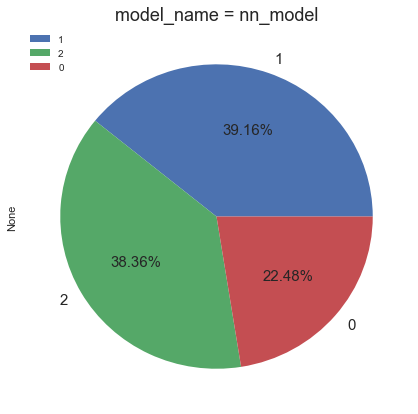

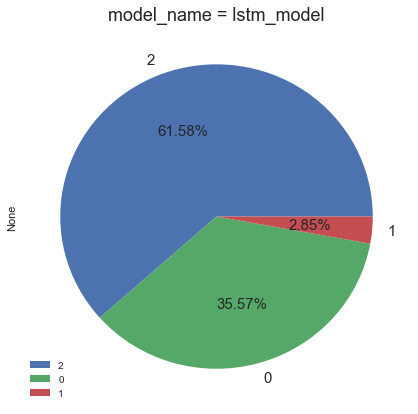

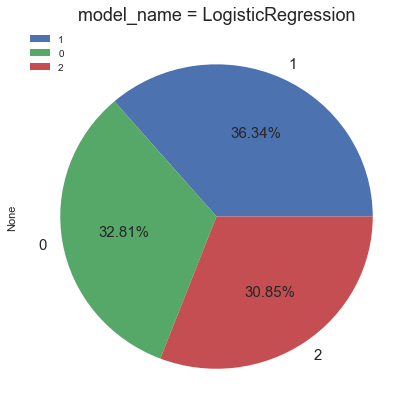

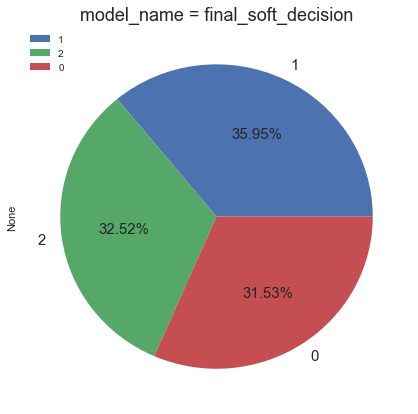

In [103]:
for model_name,model_predictions in all_soft_decisions.items():
    fig, ax = plt.subplots()
    ax.set_title("model_name = " + model_name, fontsize = 18)
    pd.Series(list(model_predictions.argmax(axis=1))).value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)